**Ce notebook établi une simulation de la stabilité dans le temps de la segmentation retenue dans le but de définir un contrat de maintenance basé sur la périodicité de ré-entraînement du modèle de segmentation.**

# Initialisation

In [13]:
# basis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# data
from google.colab import drive
drive.mount('/content/drive')

# timing managment
from tqdm import tqdm
from time import time

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Transformation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# date treatment
import sqlite3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_data = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 5/olist_data/'

# Simulation

## remarque

On remarque une subtilité : les dates brutes dans nos données de base sont au format

`yyyy/mm/dd hh:mm:ss`

Or, la fonction

`DATE(valeur_date, '+x days') `

de SQL renvoie une date au format

`yyyy/mm/dd`

Ainsi, lorsque l'on compare les dates brutes de nos données à celle renvoyée par `DATE(MAX(valeur_date), '+x days')` de la sorte :

`valeur_date <= DATE(MAX(valeur_date), '+x days')`

cela revient a faire une comparaison du type :

`(yyyy/mm/dd hh:mm:ss)_i <= (yyyy/mm/dd 00:00:00)_max`

De cette manière, tous les clients ayant commandé le même jour `yyyy/mm/dd` après minuit (càd à `hh:mm:ss > 00:00:00`) seront filtré par notre requête.

Donc pour éviter de filtrer ces clients nous ajouterons 1 jour à la date max comparée de cette manière :

`valeur_date <= DATE(MAX(valeur_date), '+(x + 1) days')`



---



En voici la démonstration avec les deux cellules suivantes.

La première contient une commande de décalage en semaine dans la requête SQL et revoie le nombre de lignes de la table orders décalée de 0 semaines.

La seconde renvoie également le nombre de lignes de la table orders mais il n'y a pas de commande de décalage.

Ainsi, nous obtenons bien le même résultat en appliquant la contrainte spécifique définie précédemment.

In [ ]:
# test de la fonction de recalcul RFM avec glissement sur les dates avec un glissement de 0 semaines

x = 0

conn = sqlite3.connect(path_data + 'olist.db')
sql = f"""
  WITH date_range_ini AS (
    SELECT *
    FROM orders
    WHERE order_purchase_timestamp <= date((SELECT MAX(order_purchase_timestamp) FROM orders), '-4 months')
    )

    SELECT c.customer_unique_id, o.order_purchase_timestamp, o.order_id
    FROM customers c
    INNER JOIN date_range_ini as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'
      AND o.order_purchase_timestamp >= date((SELECT MIN(order_purchase_timestamp) FROM orders), '+{x * 7} days')
      AND o.order_purchase_timestamp <= date((SELECT MAX(order_purchase_timestamp) FROM orders), '+{x * 7 + 1} days')

"""
pd.read_sql_query(sql, conn).shape[0]

82717

In [ ]:
# idem mais sans la commandes de variation de semaines : le résultat doit être le même que pour un glissement de zéro semaine

conn = sqlite3.connect(path_data + 'olist.db')
sql = f"""
  WITH date_range_ini AS (
    SELECT *
    FROM orders
    WHERE order_purchase_timestamp <= date((SELECT MAX(order_purchase_timestamp) FROM orders), '-4 months')
    )

    SELECT c.customer_unique_id, o.order_purchase_timestamp, o.order_id
    FROM customers c
    INNER JOIN date_range_ini as o
    ON o.customer_id = c.customer_id
    WHERE o.order_status NOT LIKE 'canceled'
      AND o.order_status NOT LIKE 'unavailable'

"""
pd.read_sql_query(sql, conn).shape[0]

82717

## fonction de mise à jour des features

Au vue de la complexité et des temps de calculs importants pour les caractéristiques de distances et de régions (states), le travail ci-dessous établie la stabilité dans le temps des caractéristiques principales seulement, à savoir :

 - Recency
 - Frequency
 - Monetary
 - Satisfaction mean
 - Installments number mean

 Ces caractéristiques sont recalculées à chaque itération temporelle avec des commandes SQL.

In [21]:
# fonction qui recalcul les features de segmentation principale en SQL
# dans l'ordre RFMSI

def compute_RFMSI(months_period, x):
  """
  return the RFMSI tab slided of x weeks from initials dates ref.
  initials dates ref being :

    [date_min, date_max]

  with :
    date_min = SELECT MIN(order_purchase_timestamp) FROM orders
    date_max = date((SELECT MAX(order_purchase_timestamp) FROM orders), '-months_period months')

  param:
     ->    months_period as int : corresponds to the plage months for sliding data
     ->    x as int : corresponds to the number of weeks to slide data
  """

  conn = sqlite3.connect(path_data + 'olist.db')
  sql = f"""
    WITH valid_order AS (
      SELECT *
      FROM orders
      WHERE order_status NOT LIKE 'canceled'
        AND order_status NOT LIKE 'unavailable'
    ),

    date_range_ini AS (
      SELECT *
      FROM valid_order
      WHERE order_purchase_timestamp <= date((SELECT MAX(order_purchase_timestamp) FROM valid_order), '-{months_period} months')
      ),

    customer_order_table AS (
      SELECT c.customer_unique_id, o.order_purchase_timestamp, o.order_id
      FROM customers c
      INNER JOIN orders as o
      ON o.customer_id = c.customer_id
      WHERE o.order_purchase_timestamp <= date((SELECT MAX(order_purchase_timestamp) FROM date_range_ini), '+{(x * 7) + 1} days')
      ),
    value_table AS (
      SELECT o.*, SUM(v.payment_value) AS monetary, SUM(v.payment_installments) AS installment
      FROM order_pymts v
      INNER JOIN customer_order_table o
      ON o.order_id = v.order_id
      GROUP BY v.order_id
    ),
    main_table AS (
      SELECT v.*, r.review_score
      FROM value_table v
      INNER JOIN order_reviews AS r
      ON v.order_id = r.order_id

    )
    SELECT  MIN(julianday((SELECT MAX(order_purchase_timestamp) FROM main_table)) - julianday(order_purchase_timestamp)) AS recency,
            COUNT(order_id) AS frequency,
            SUM(monetary) AS monetary,
            AVG(review_score) AS satisfaction_mean,
            AVG(installment) AS installment_mean
    FROM main_table
    GROUP BY customer_unique_id;
  """
  return pd.read_sql_query(sql, conn)

## simulation de la segmention dans le temps

In [14]:
# calcul du nombre de semaines entières entre la date maximale du tableau initial et la date maximale dans la table orders

def nb_semaine_iteration_simu(months):
  """
  return number of complete weeks of iterate simulation based on a giving number of months

  param :
   - months (int)
  """

  conn = sqlite3.connect(path_data + 'olist.db')
  sql = f"""

    WITH date_filter AS (
      SELECT *
      FROM orders
      WHERE order_status NOT LIKE 'canceled'
        AND order_status NOT LIKE 'unavailable'
    ),

    date_tab AS (
      SELECT date((SELECT MAX(order_purchase_timestamp) FROM date_filter), '-{months} months') AS date_ref_droite,
             MAX(order_purchase_timestamp) AS date_max
      FROM date_filter
    )
    SELECT (julianday(date_max) - julianday(date_ref_droite))/7 AS delta_days
    FROM date_tab
  """

  delta_weeks = math.ceil(pd.read_sql_query(sql, conn).delta_days.values[0])

  print(f'En prenant une période de glissement des données de {months} mois nous pouvons itérer la simulation sur {delta_weeks} semaines')

  return delta_weeks

In [19]:
nb_semaine_iteration_simu(4)

En prenant une période de glissement des données de 4 mois nous pouvons itérer la simulation sur 18 semaines


18

Analyse de la stabilité de ce modèle dans le temps :

In [22]:
def simulation_cluster(months_period, step):
  """
  return simulation plot of cluster stability in the months_period with iteration on step week(s)

  param :
    - months_period (int)
    - step (int)
  """

  # calcul du nombre de semaines sur la période à simuler
  rg = nb_semaine_iteration_simu(months_period) + 1

  ari_scores = []

  # calcul des caractéristiques initiales de référence
  features_ref = compute_RFMSI(months_period, 0)

  # scaling
  minmax_model_0 = MinMaxScaler()
  data_ref = minmax_model_0.fit_transform(features_ref)

  # entraînement d'un modèle initial de référence
  model_ref = KMeans(n_clusters= 4, random_state= 42).fit(data_ref)


  for sem in tqdm(range(0, rg , step)):

    # calcul des caractéristiques de segmentation
    features_slided = compute_RFMSI(months_period, sem)

    # scaling
    minmax_model_1 = MinMaxScaler()
    data_slided = minmax_model_1.fit_transform(features_slided)

    # scaling avec le transformer de référence
    data_slided_0 = minmax_model_0.transform(features_slided)

    # entraînement d'un nouveau modèle
    model_slided = KMeans(n_clusters= 4, random_state= 42).fit(data_slided)

    # score de stabilité
    labels_model_ref = model_ref.predict(data_slided_0) # labels predient par ancien model
    labels_model_slided = model_slided.predict(data_slided) # labels predient par nouveau model

    # score de stabilité
    ari_scores.append(adjusted_rand_score(labels_model_ref, labels_model_slided))


  # affichage graphique
  x = [sem for sem in range(0, rg , step)]
  y = ari_scores
  sns.lineplot(x = x, y = y)

  n = np.argmax(pd.Series(y) <= 0.8)
  #display(n, n-1, x, y, x[n-1], y[n-1])
  x_lim = x[n]
  y_lim = y[n]

  maintenance = f"Maintenance de l'algorythme nécessaire\ntous les {x_lim} semaines."

  # plot horizontale line at 80%
  plt.plot(np.linspace(0, x_lim, 2), 2 * [y_lim], color='black', linestyle= '--')
  # plot verticale line at date_lim
  plt.plot(2 * [x_lim], np.linspace(0, y_lim, 2), color='black', linestyle= '--')

  plt.text(min(x), y_lim - .1, s= maintenance, color='r')

  plt.title(f'Evolution temporelle toutes les {step} semaine(s) \nde la stabilité de la segmentation sur une période de {months_period} mois')
  plt.ylabel('ARI score ([0, 1])')
  plt.xlabel('Evolution en semaines')

  plt.xlim(min(x), max(x))
  plt.ylim(0, 1)
  plt.grid()

Mesure de la stabilité semaine après semaines sur une période de 4 mois :

---



En prenant une période de glissement des données de 4 mois nous pouvons itérer la simulation sur 18 semaines


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  5%|▌         | 1/19 [00:05<01:32,  5.14s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 2/19 [00:09<01:18,  4.60s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

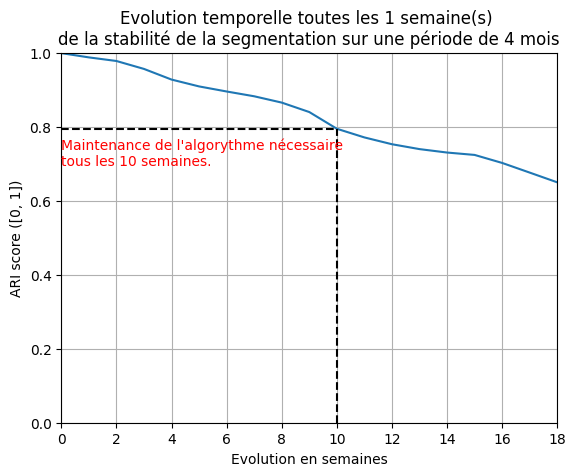

In [23]:
simulation_cluster(months_period= 4, step= 1)

Mesure cette fois toutes les deux semaines sur la même période :


---



En prenant une période de glissement des données de 4 mois nous pouvons itérer la simulation sur 18 semaines


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 1/10 [00:04<00:38,  4.25s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 20%|██        | 2/10 [00:08<00:33,  4.20s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

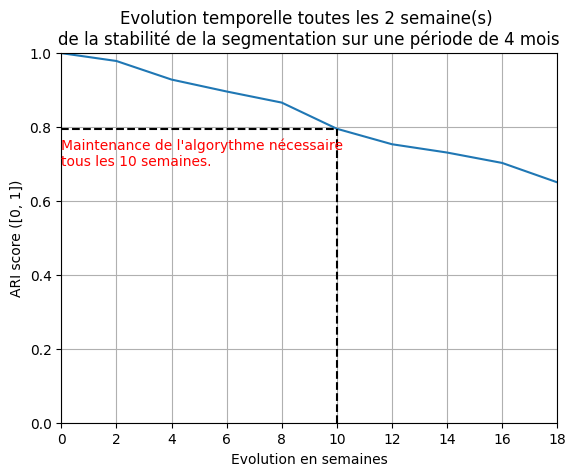

In [24]:
simulation_cluster(months_period= 4, step= 2)

En prenant une période de glissement des données de 8 mois nous pouvons itérer la simulation sur 35 semaines


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  6%|▌         | 1/18 [00:04<01:11,  4.22s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 2/18 [00:07<01:00,  3.78s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

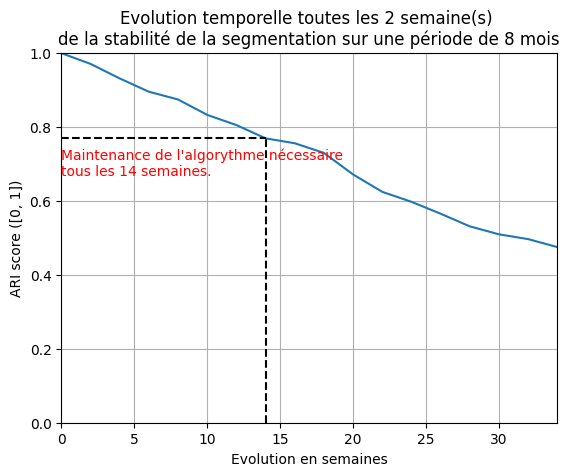

In [25]:
simulation_cluster(months_period= 8, step= 2)

En prenant une période de glissement des données de 8 mois nous pouvons itérer la simulation sur 35 semaines


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/36 [00:03<01:58,  3.39s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  6%|▌         | 2/36 [00:07<02:08,  3.79s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

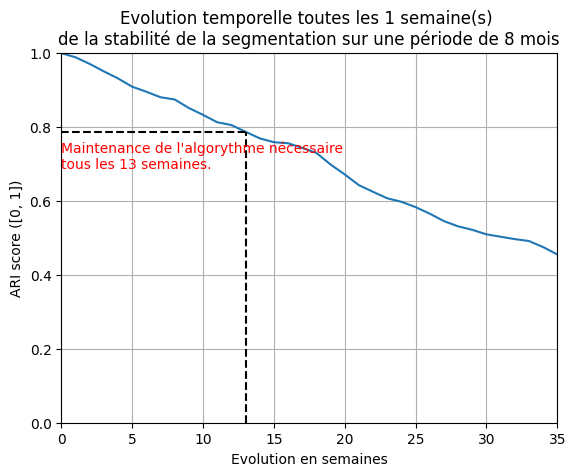

In [26]:
simulation_cluster(months_period= 8, step= 1)

Pour le contrat de maintenance de la segmentation, nous pourrons établir une base de ré-entraînement des modèles toutes les 10 semaines pour garantir une bonne qualité des groupes clients.